In [84]:
# --- Imports ---
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score

import matplotlib.pyplot as plt






In [85]:
print("=" * 70)
print("STEP 1: LOADING AND PREPARING THE DATA")
print("=" * 70)

# 1) Load the dataset
print("Loading Air Quality dataset...")
df = pd.read_csv('..\..\datasets\AirQualityUCI.csv', sep=';', decimal=',')

print(f"Dataset shape: {df.shape}")
print(f"Dataset columns: {df.columns.tolist()}")

# 2) Handle the missing values (-200 -> NaN)
print("\nHandling missing values...")
df_clean = df.replace(-200.0, np.nan)

# 3) Features and target
features = ['T', 'RH', 'AH']
target = 'CO(GT)'

# 4) Check if required columns exist
missing_cols = [col for col in features + [target] if col not in df_clean.columns]
if missing_cols:
    print(f"Warning: Missing columns: {missing_cols}")
    print("Available columns:")
    for col in df_clean.columns:
        print(f"  - {col}")
    raise ValueError("Required columns not found!")

# 5) Select required columns and remove rows with NaN
df_model = df_clean[features + [target]].dropna()

print(f"Dataset shape after cleaning: {df_model.shape}")
print(f"Removed {len(df_clean) - len(df_model)} rows with missing values")

# 6) Prepare X, y
X = df_model[features]
y = df_model[target]

# 7) Split the data into train and test (70/30)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42
)

print(f"\nData split completed:")
print(f"Training set: {X_train.shape[0]} samples")
print(f"Testing set:  {X_test.shape[0]} samples")



STEP 1: LOADING AND PREPARING THE DATA
Loading Air Quality dataset...
Dataset shape: (9471, 17)
Dataset columns: ['Date', 'Time', 'CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)', 'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH', 'Unnamed: 15', 'Unnamed: 16']

Handling missing values...
Dataset shape after cleaning: (7344, 4)
Removed 2127 rows with missing values

Data split completed:
Training set: 5140 samples
Testing set:  2204 samples


In [86]:
print("\n" + "=" * 70)
print("STEP 2: FITTING MODELS OF INCREASING COMPLEXITY (with StandardScaler)")
print("=" * 70)

# 1) Standardization (for numerical stability)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# 2) List for storing results
degrees = list(range(1, 11))  # 1..10
train_errors, test_errors = [], []
train_r2_scores, test_r2_scores = [], []
model_complexities = []

print("Fitting polynomial regression models...")

# 3) For each degree, generate polynomial features + fit linear regression
for degree in degrees:
    print(f"Processing degree {degree}...", end=" ")

    # Polynomial features
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    X_train_poly = poly.fit_transform(X_train_scaled)
    X_test_poly  = poly.transform(X_test_scaled)

    # Model complexity (#features)
    model_complexities.append(X_train_poly.shape[1])

    # Linear regression
    model = LinearRegression()
    model.fit(X_train_poly, y_train)

    # Predictions
    y_train_pred = model.predict(X_train_poly)
    y_test_pred  = model.predict(X_test_poly)

    # Errors and scores
    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse  = mean_squared_error(y_test, y_test_pred)
    train_r2  = r2_score(y_train, y_train_pred)
    test_r2   = r2_score(y_test, y_test_pred)

    train_errors.append(train_mse)
    test_errors.append(test_mse)
    train_r2_scores.append(train_r2)
    test_r2_scores.append(test_r2)

    print(f"Features: {X_train_poly.shape[1]:3d}, Train MSE: {train_mse:.4f}, Test MSE: {test_mse:.4f}")

# 4) Optimal degree (test error min)
optimal_degree_idx = int(np.argmin(test_errors))
optimal_degree = degrees[optimal_degree_idx]
min_test_error = test_errors[optimal_degree_idx]

print(f"\nOptimal degree: {optimal_degree} (Test MSE: {min_test_error:.4f})")




STEP 2: FITTING MODELS OF INCREASING COMPLEXITY (with StandardScaler)
Fitting polynomial regression models...
Processing degree 1... Features:   3, Train MSE: 2.0423, Test MSE: 2.0562
Processing degree 2... Features:   9, Train MSE: 2.0197, Test MSE: 2.0254
Processing degree 3... Features:  19, Train MSE: 2.0048, Test MSE: 2.0237
Processing degree 4... Features:  34, Train MSE: 1.9914, Test MSE: 2.0210
Processing degree 5... Features:  55, Train MSE: 1.9705, Test MSE: 2.0016
Processing degree 6... Features:  83, Train MSE: 1.9395, Test MSE: 1.9889
Processing degree 7... Features: 119, Train MSE: 1.9284, Test MSE: 1.9883
Processing degree 8... Features: 164, Train MSE: 1.9112, Test MSE: 2.0245
Processing degree 9... Features: 219, Train MSE: 1.8956, Test MSE: 2.0721
Processing degree 10... Features: 285, Train MSE: 1.8739, Test MSE: 2.2969

Optimal degree: 7 (Test MSE: 1.9883)



STEP 3: PLOTTING VALIDATION CURVE


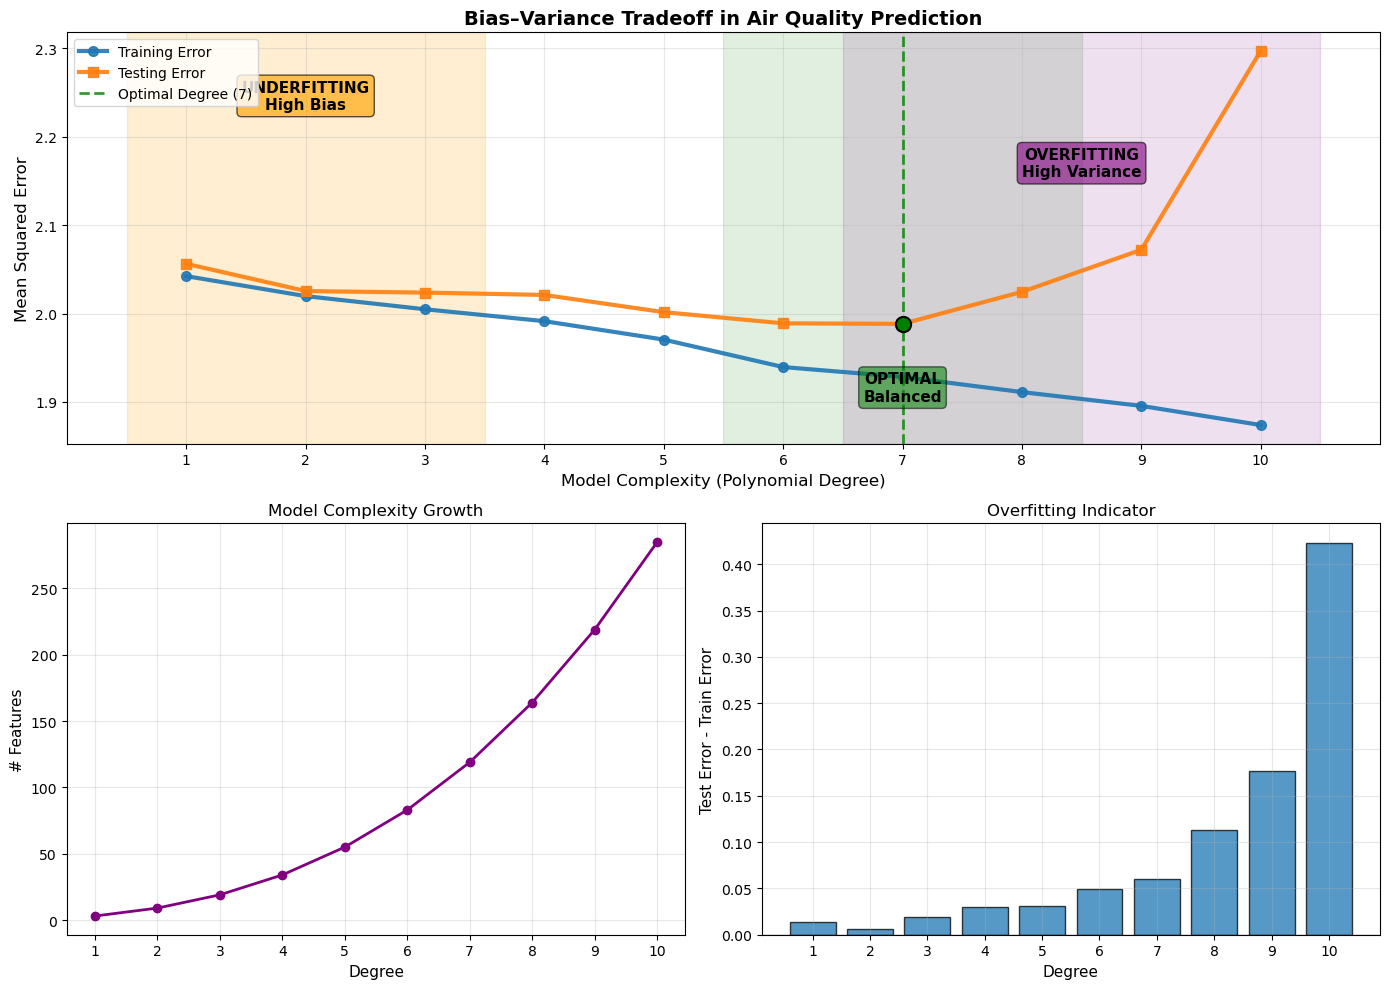

In [87]:
print("\n" + "=" * 70)
print("STEP 3: PLOTTING VALIDATION CURVE")
print("=" * 70)

# More balanced figure
plt.figure(figsize=(14, 10))

# --- Top graph ---
plt.subplot(2, 2, (1, 2))
plt.plot(degrees, train_errors, 'o-', label='Training Error', color='C0',
         linewidth=3, markersize=7, alpha=0.9)
plt.plot(degrees, test_errors,  's-', label='Testing Error',  color='C1',
         linewidth=3, markersize=7, alpha=0.9)

# Optimal point
plt.axvline(x=optimal_degree, color='green', linestyle='--', linewidth=2, alpha=0.8,
            label=f'Optimal Degree ({optimal_degree})')
plt.scatter(optimal_degree, min_test_error, color='green', s=120, zorder=5,
            edgecolor='black', linewidth=1.5)

# Region shading
mx = max(max(train_errors), max(test_errors))
mn = min(min(train_errors), min(test_errors))
rng = mx - mn if mx > mn else 1.0

# Underfitting (1–3)
plt.axvspan(0.5, 3.5, color='orange', alpha=0.18)
plt.text(2, mx - 0.12*rng, 'UNDERFITTING\nHigh Bias', ha='center', va='center',
         fontsize=11, fontweight='bold',
         bbox=dict(boxstyle="round,pad=0.3", facecolor='orange', alpha=0.65))

# Optimal band
opt_l, opt_r = max(1, optimal_degree-1), min(10, optimal_degree+1)
plt.axvspan(opt_l-0.5, opt_r+0.5, color='green', alpha=0.12)
plt.text(optimal_degree, mn + 0.10*rng, 'OPTIMAL\nBalanced', ha='center', va='center',
         fontsize=11, fontweight='bold',
         bbox=dict(boxstyle="round,pad=0.3", facecolor='green', alpha=0.55))

# Overfitting (7–10)
plt.axvspan(6.5, 10.5, color='purple', alpha=0.12)
plt.text(8.5, mx - 0.30*rng, 'OVERFITTING\nHigh Variance', ha='center', va='center',
         fontsize=11, fontweight='bold',
         bbox=dict(boxstyle="round,pad=0.3", facecolor='purple', alpha=0.60))

plt.xlabel('Model Complexity (Polynomial Degree)', fontsize=12)
plt.ylabel('Mean Squared Error', fontsize=12)
plt.title('Bias–Variance Tradeoff in Air Quality Prediction', fontsize=14, fontweight='bold')
plt.legend(fontsize=10, loc='upper left')
plt.grid(True, alpha=0.3)
plt.xticks(degrees)

# --- Bottom left: Model complexity ---
plt.subplot(2, 2, 3)
plt.plot(degrees, model_complexities, 'o-', color='purple', linewidth=2, markersize=6)
plt.xlabel('Degree', fontsize=11)
plt.ylabel('# Features', fontsize=11)
plt.title('Model Complexity Growth', fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(degrees)

# --- Bottom right: Overfitting indicator (test-train gap) ---
plt.subplot(2, 2, 4)
gap = np.array(test_errors) - np.array(train_errors)
bars = plt.bar(degrees, gap, alpha=0.75, edgecolor='black')
plt.axhline(0, color='black', linewidth=1, alpha=0.5)
plt.xlabel('Degree', fontsize=11)
plt.ylabel('Test Error - Train Error', fontsize=11)
plt.title('Overfitting Indicator', fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(degrees)


plt.tight_layout()
plt.show()



In [88]:
print("\n" + "=" * 70)
print("SUMMARY TABLE")
print("=" * 70)

print(f"{'Deg':<4} {'Feats':<6} {'Train MSE':<12} {'Test MSE':<12} "
      f"{'Gap':<10} {'R² Test':<10} {'Status':<12}")
print("-" * 80)

for i, d in enumerate(degrees):
    g = test_errors[i] - train_errors[i]
    if d <= 3:
        status = "Underfit"
    elif d == optimal_degree:
        status = "OPTIMAL"
    elif g > min_test_error * 0.3:
        status = "Overfit"
    else:
        status = "OK"

    print(f"{d:<4} {model_complexities[i]:<6} {train_errors[i]:<12.4f} "
          f"{test_errors[i]:<12.4f} {g:<10.4f} {test_r2_scores[i]:<10.4f} "
          f"{status:<12}")

print("-" * 80)



SUMMARY TABLE
Deg  Feats  Train MSE    Test MSE     Gap        R² Test    Status      
--------------------------------------------------------------------------------
1    3      2.0423       2.0562       0.0139     0.0080     Underfit    
2    9      2.0197       2.0254       0.0057     0.0229     Underfit    
3    19     2.0048       2.0237       0.0188     0.0237     Underfit    
4    34     1.9914       2.0210       0.0297     0.0250     OK          
5    55     1.9705       2.0016       0.0310     0.0344     OK          
6    83     1.9395       1.9889       0.0494     0.0405     OK          
7    119    1.9284       1.9883       0.0599     0.0408     OPTIMAL     
8    164    1.9112       2.0245       0.1134     0.0233     OK          
9    219    1.8956       2.0721       0.1765     0.0004     OK          
10   285    1.8739       2.2969       0.4229     -0.1081    OK          
--------------------------------------------------------------------------------


In [89]:
# Cell 5: 5-FOLD CROSS-VALIDATION OVER POLYNOMIAL DEGREES
cv_train_scores = []    # Training MSE on full data (pipeline fitted on all X,y)
cv_test_scores  = []    # Mean CV MSE across folds
cv_test_std     = []    # Std of CV MSE across folds

# Reproducible shuffled 5-fold CV
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for d in degrees:
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('poly', PolynomialFeatures(degree=d, include_bias=False)),
        ('linear', LinearRegression())
    ])
    
    # 5-fold CV (sklearn returns negative MSE for "neg_mean_squared_error")
    cv_scores = cross_val_score(pipeline, X, y, cv=kf, scoring='neg_mean_squared_error')
    cv_mse = -cv_scores  # Convert to positive MSE
    
    # Fit on full data to get a reference training MSE
    pipeline.fit(X, y)
    y_pred_full = pipeline.predict(X)
    train_mse_cv = mean_squared_error(y, y_pred_full)
    
    # Store results
    cv_train_scores.append(train_mse_cv)
    cv_test_scores.append(cv_mse.mean())
    cv_test_std.append(cv_mse.std())

    print(f"Degree {d:2d} | Train MSE (full) {train_mse_cv:8.4f} | "
          f"CV MSE {cv_mse.mean():8.4f} ± {cv_mse.std():6.4f}")

# Optimal degree (lowest mean CV MSE)
optimal_idx_cv    = int(np.argmin(cv_test_scores))
optimal_degree_cv = degrees[optimal_idx_cv]
min_test_error_cv = cv_test_scores[optimal_idx_cv]

print(f"\n🎯 Optimal (CV) degree: {optimal_degree_cv}  |  CV MSE: {min_test_error_cv:.4f}")


Degree  1 | Train MSE (full)   2.0461 | CV MSE   2.0482 ± 0.1116
Degree  2 | Train MSE (full)   2.0206 | CV MSE   2.0259 ± 0.1120
Degree  3 | Train MSE (full)   2.0087 | CV MSE   2.0175 ± 0.1129
Degree  4 | Train MSE (full)   1.9969 | CV MSE   2.0158 ± 0.1059
Degree  5 | Train MSE (full)   1.9738 | CV MSE   2.0166 ± 0.1207
Degree  6 | Train MSE (full)   1.9456 | CV MSE   1.9873 ± 0.0992
Degree  7 | Train MSE (full)   1.9354 | CV MSE   2.0200 ± 0.1368
Degree  8 | Train MSE (full)   1.9242 | CV MSE   2.0141 ± 0.1116
Degree  9 | Train MSE (full)   1.9115 | CV MSE   2.4542 ± 0.8713
Degree 10 | Train MSE (full)   1.8942 | CV MSE   3.0119 ± 1.7760

🎯 Optimal (CV) degree: 6  |  CV MSE: 1.9873


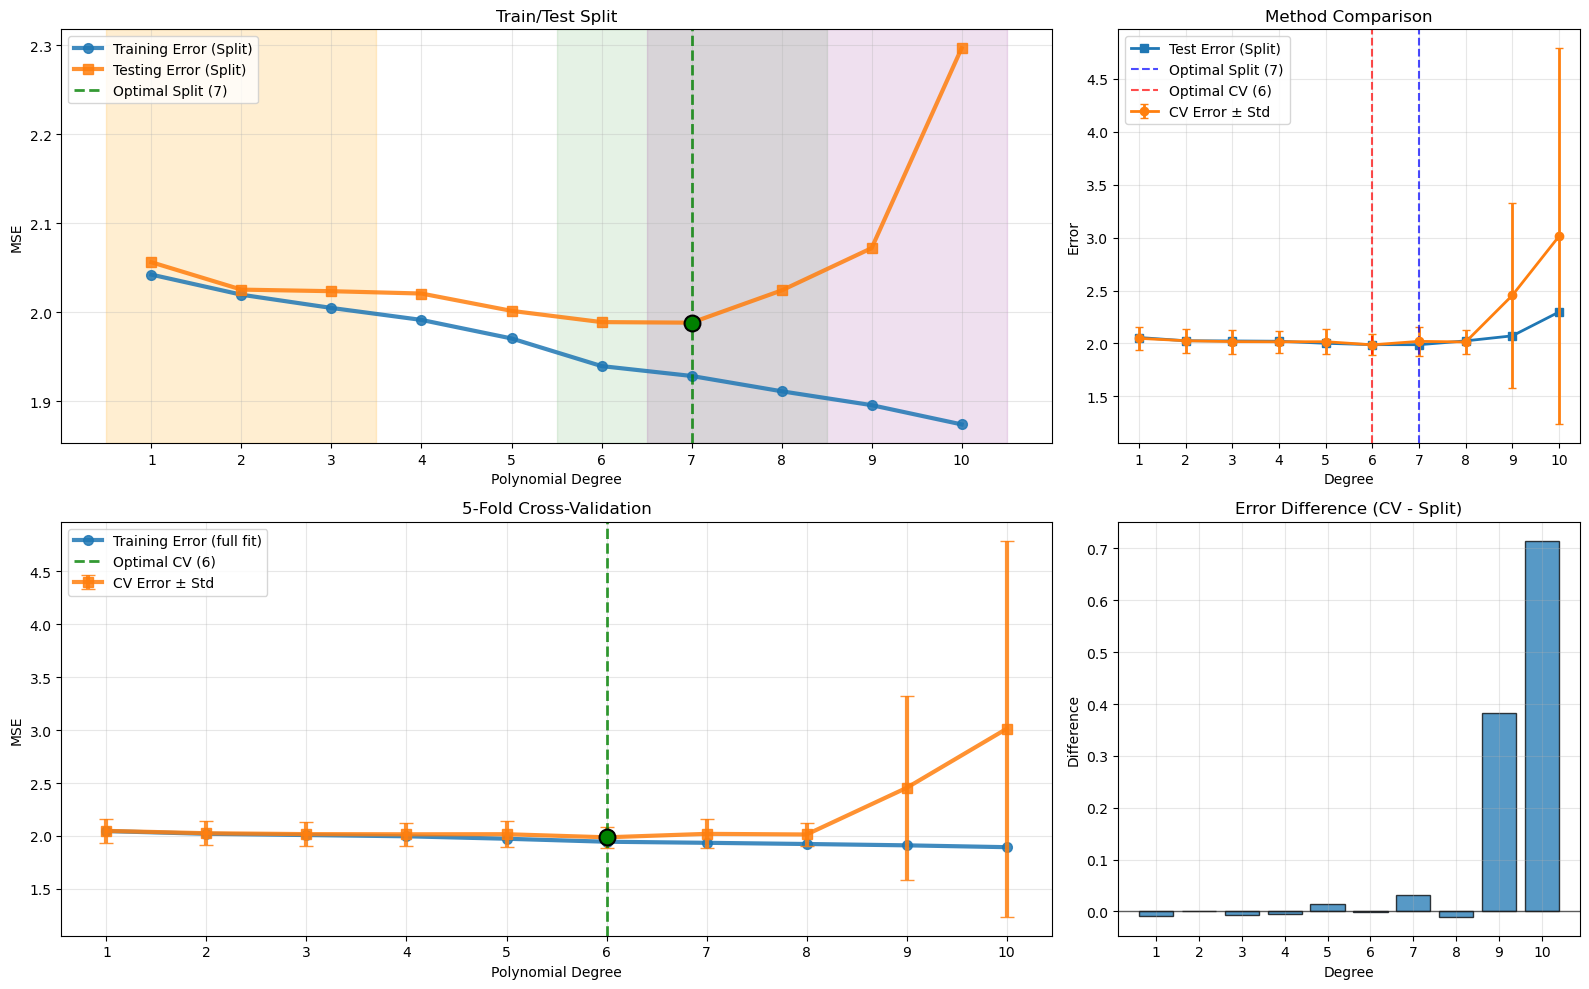

In [90]:
# Cell 6: Comparison plots

plt.figure(figsize=(16,10))

# Split results
plt.subplot(2,3,(1,2))
plt.plot(degrees, train_errors, 'o-', label='Training Error (Split)', linewidth=3, markersize=7, alpha=0.85)
plt.plot(degrees, test_errors,  's-', label='Testing Error (Split)',  linewidth=3, markersize=7, alpha=0.85)
plt.axvline(optimal_degree, linestyle='--', color='green', linewidth=2, alpha=0.8,
            label=f'Optimal Split ({optimal_degree})')
plt.scatter([optimal_degree], [min_test_error], s=130, color='green', zorder=5, edgecolor='black', linewidth=1.5)
plt.axvspan(0.5, 3.5, color='orange', alpha=0.18)
plt.axvspan(max(1, optimal_degree-1)-0.5, min(10, optimal_degree+1)+0.5, color='green', alpha=0.10)
plt.axvspan(6.5, 10.5, color='purple', alpha=0.12)
plt.title('Train/Test Split')
plt.xlabel('Polynomial Degree'); plt.ylabel('MSE'); plt.xticks(degrees); plt.grid(True, alpha=0.3); plt.legend()

# CV results
plt.subplot(2,3,(4,5))
plt.plot(degrees, cv_train_scores, 'o-', label='Training Error (full fit)', linewidth=3, markersize=7, alpha=0.85)
plt.errorbar(degrees, cv_test_scores, yerr=cv_test_std, fmt='s-', 
             label='CV Error ± Std', linewidth=3, markersize=7, alpha=0.85, capsize=5)
plt.axvline(optimal_degree_cv, linestyle='--', color='green', linewidth=2, alpha=0.8,
            label=f'Optimal CV ({optimal_degree_cv})')
plt.scatter([optimal_degree_cv], [min_test_error_cv], s=130, color='green', zorder=5, edgecolor='black', linewidth=1.5)
plt.title('5-Fold Cross-Validation')
plt.xlabel('Polynomial Degree'); plt.ylabel('MSE'); plt.xticks(degrees); plt.grid(True, alpha=0.3); plt.legend()

# Direct error comparison
plt.subplot(2,3,3)
plt.plot(degrees, test_errors, 's-', label='Test Error (Split)', linewidth=2, markersize=6)
plt.errorbar(degrees, cv_test_scores, yerr=cv_test_std, fmt='o-', label='CV Error ± Std', 
             linewidth=2, markersize=6, capsize=3)
plt.axvline(optimal_degree, linestyle='--', color='blue', alpha=0.7, label=f'Optimal Split ({optimal_degree})')
plt.axvline(optimal_degree_cv, linestyle='--', color='red', alpha=0.7, label=f'Optimal CV ({optimal_degree_cv})')
plt.title('Method Comparison')
plt.xlabel('Degree'); plt.ylabel('Error'); plt.xticks(degrees); plt.grid(True, alpha=0.3); plt.legend()

# Error difference (CV - Split)
plt.subplot(2,3,6)
error_diff = np.array(cv_test_scores) - np.array(test_errors)
plt.bar(degrees, error_diff, alpha=0.75, edgecolor='black')
plt.axhline(0, color='black', linewidth=1, alpha=0.6)
plt.title('Error Difference (CV - Split)')
plt.xlabel('Degree'); plt.ylabel('Difference'); plt.xticks(degrees); plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [91]:
# Cell 7: Tables & summary

print("="*90)
print("COMPARISON SUMMARY: TRAIN/TEST SPLIT vs CROSS-VALIDATION")
print("="*90)
print(f"{'Method':<20} {'Optimal Degree':<15} {'Best Error':<15} {'Difference':<15}")
print("-"*90)
print(f"{'Train/Test Split':<20} {optimal_degree:<15} {min_test_error:<15.4f} {'Baseline':<15}")
print(f"{'Cross-Validation':<20} {optimal_degree_cv:<15} {min_test_error_cv:<15.4f} "
      f"{(min_test_error_cv - min_test_error):<15.4f}")
print("-"*90)

print("\n" + "="*90)
print("DETAILED COMPARISON TABLE")
print("="*90)
print(f"{'Deg':<4} {'Split Train':<12} {'Split Test':<12} {'CV Train(full)':<14} {'CV Test(mean)':<14} {'CV Std':<10} {'Diff(CV-Test)':<14}")
print("-"*90)
for i, d in enumerate(degrees):
    diff = cv_test_scores[i] - test_errors[i]
    print(f"{d:<4} {train_errors[i]:<12.4f} {test_errors[i]:<12.4f} "
          f"{cv_train_scores[i]:<14.4f} {cv_test_scores[i]:<14.4f} {cv_test_std[i]:<10.4f} {diff:<14.4f}")
print("-"*90)

print("\n" + "="*90)
print("ANALYSIS")
print("="*90)
if optimal_degree != optimal_degree_cv:
    print(f"• Split selects degree {optimal_degree}, CV selects degree {optimal_degree_cv} → model selection is sensitive to data split.")
else:
    print(f"• Both methods agree on degree {optimal_degree}.")

diff_best = min_test_error_cv - min_test_error
if abs(diff_best) > 0.1:
    if diff_best > 0:
        print("• CV error is higher (more conservative, robust estimate).")
    else:
        print("• CV error is lower (rare; check variance/noise).")
else:
    print("• Errors are similar between methods.")


COMPARISON SUMMARY: TRAIN/TEST SPLIT vs CROSS-VALIDATION
Method               Optimal Degree  Best Error      Difference     
------------------------------------------------------------------------------------------
Train/Test Split     7               1.9883          Baseline       
Cross-Validation     6               1.9873          -0.0010        
------------------------------------------------------------------------------------------

DETAILED COMPARISON TABLE
Deg  Split Train  Split Test   CV Train(full) CV Test(mean)  CV Std     Diff(CV-Test) 
------------------------------------------------------------------------------------------
1    2.0423       2.0562       2.0461         2.0482         0.1116     -0.0080       
2    2.0197       2.0254       2.0206         2.0259         0.1120     0.0005        
3    2.0048       2.0237       2.0087         2.0175         0.1129     -0.0062       
4    1.9914       2.0210       1.9969         2.0158         0.1059     -0.0053       
5

## 🧩 Step 4 — Discussion 

### **Which polynomial degree gives the best generalization?**
According to the bias–variance tradeoff curve, the **7th-degree polynomial** gives the best generalization performance.  
At this point, the testing error reaches its minimum, meaning the model captures the underlying nonlinear relationship between temperature (T), relative humidity (RH), and absolute humidity (AH) with CO concentration (CO(GT)) without overfitting.  
Models with lower degrees underfit the data, while models with higher degrees start to fit noise and lose generalization capability.

---

### **How do the training and testing errors change as the degree increases?**
The **training error** decreases steadily as model complexity increases, because higher-degree polynomials can better fit the training samples.  
The **testing error**, however, decreases initially as the model begins to capture the underlying structure of the data, but after reaching degree 7, it begins to rise again.  
This indicates that while the model becomes more flexible, it also starts capturing noise from the training data, leading to poorer generalization.  


---

### **How do bias and variance manifest in this dataset?**
For **low-degree models (1–3)**, both training and testing errors are high and close, showing that the model cannot capture the complex interactions between the meteorological features and CO concentration — this reflects **high bias** and **underfitting**.  
For **high-degree models (8–10)**, the training error is very low but the testing error increases sharply, indicating **high variance** and **overfitting**.  
The **7th-degree** model represents the **balanced region**, where bias is sufficiently reduced and variance is still under control, leading to the best generalization.

---

### **How might sensor noise or missing data affect the bias–variance tradeoff?**
Since this dataset is collected from physical sensors, it likely contains **measurement noise** and **missing values**.

- **Noise (measurement errors):**  
  High-degree polynomial models may interpret random fluctuations as meaningful patterns, effectively *overfitting* to noise.  
  This increases **variance** and reduces the model’s generalization ability.

- **Missing data:**  
  Reduces the total amount of usable information, which can weaken the model’s learning and lead to **unstable predictions**.

Therefore, highly complex models are risky when dealing with sensor data.  
Simpler polynomial models (e.g., degrees **5–7**) tend to produce **more stable and reliable results** under these real-world conditions.

---

### **Cross-Validation Comparison**

When applying 5-fold cross-validation instead of a single train/test split, the optimal polynomial degree shifted slightly from **7 to 6**.  
This difference is expected because cross-validation provides a more reliable estimate of model performance by averaging results over multiple data partitions, reducing the influence of a single random split.  
Overall, both methods indicate that **moderate model complexity (around degree 6–7)** achieves the best balance between bias and variance.  
Cross-validation gives a more stable and conservative estimate of generalization error, confirming that the model’s performance is consistent across different subsets of the dataset.

